In [1]:
%matplotlib inline

from __future__ import division
import numpy as np
import menpo.io as mio
from menpo.image import Image
from menpo.feature import greyscale, normalize_norm, normalize_std, fast_dsift
from menpo.landmark import labeller, ibug_face_66
from menpo.visualize import visualize_images, print_dynamic, progress_bar_str
from menpofit.visualize import visualize_fitting_results
from alaborticcv2015.alignment import LKFitter, FilteredSSD, FilteredFourierSSD

# Intensities LK

Load training data:

In [2]:
images = []
for i in mio.import_images('/data/PhD/DataBases/faces/multipie/', verbose=True, 
                           max_images=66):
    i.crop_to_landmarks_proportion_inplace(0.5)
    i = i.rescale_landmarks_to_diagonal_range(200)
    labeller(i, 'PTS', ibug_face_66)
    lms = i.landmarks['ibug_face_66'].lms
    bb = lms.bounding_box()
    i.landmarks['bounding_box'] = bb
    images.append(i)

- Loading 66 assets: [====================] 100%

In [3]:
indices = [[j + k for j in range(3)] for k in range(6, 66, 15)]
indices = [j for k in indices for j in k] 

template = images[indices[0]]
test_images = [images[j] for j in indices][:3]

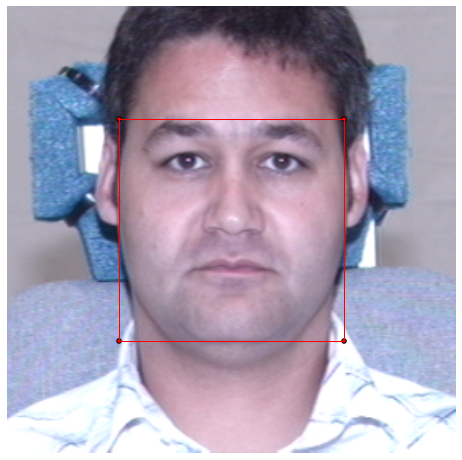

In [4]:
visualize_images(template)

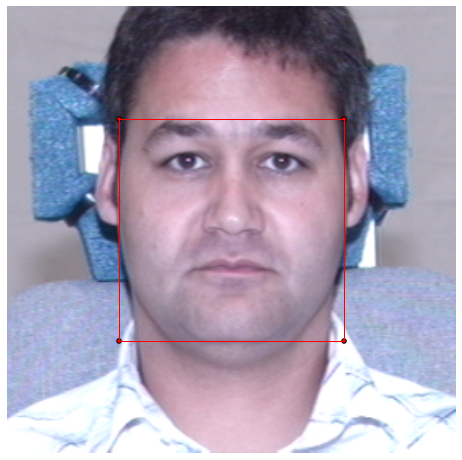

In [5]:
visualize_images(test_images)

Create an LK fitter:

In [6]:
fitter = LKFitter(template,
                  group='bounding_box',
                  features=greyscale,
                  diagonal=100,
                  residual_cls=FilteredSSD)

/data/pythondev/src/menpo/menpo/image/base.py:130: UserWarning: The copy flag was NOT honoured. A copy HAS been made. Please ensure the data you pass is C-contiguous.
  warn('The copy flag was NOT honoured. A copy HAS been made. '


Align:

In [7]:
n_rep = 50
np.random.seed(seed=1)

fitter_results = []
for j, i in enumerate(test_images):
    string = '- Image {}: '.format(j)
    
    frs = []
    for k in range(n_rep):
        print_dynamic('{}{}'.format(
            string, progress_bar_str(k/n_rep, show_bar=True)))
        
        gt_s = i.landmarks['bounding_box'].lms
        s = fitter.perturb_shape(gt_s, noise_std=10)
        fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=25)
        fr.downscale = 0.5
        frs.append(fr)
    
    fitter_results += frs
    
    errors = [fr.final_error() for fr in frs]    
    mean = np.mean(errors)
    median = np.median(errors)
    std = np.std(errors)

    print_dynamic(string + 
                  '\tmean={0:.4f}  median={1:.4f}  std={2:.4f}\n'.format(mean, median, std))
    
errors = [fr.final_error() for fr in fitter_results]    
mean = np.mean(errors)
median = np.median(errors)
std = np.std(errors)

print_dynamic('- Total:   ' + 
              '\tmean={0:.4f}  median={1:.4f}  std={2:.4f}\n'.format(mean, median, std))

- Image 0: 	mean=0.0013  median=0.0013  std=0.0003
- Image 1: 	mean=0.1453  median=0.1442  std=0.0080
- Image 2: 	mean=0.0764  median=0.0760  std=0.0043
- Total:   	mean=0.0743  median=0.0760  std=0.0590


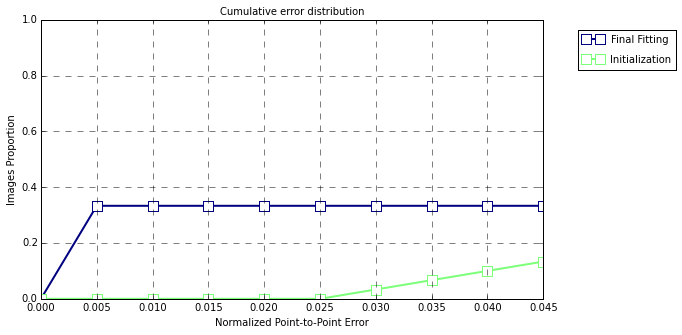

In [8]:
visualize_fitting_results(fitter_results)